In [25]:
!pip install -q datasets torch transformers


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModel

In [27]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.5.1+cu121
CUDA available: True


In [28]:
file_path = '/kaggle/input/restaurant-feedbacks/final_data.txt'

In [29]:
def read_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            file_content = f.read()
        return file_content
    except FileNotFoundError:
        print(f"Cant find file: {file_path}")
        return ""
    except Exception as e:
        print(f"Error: {e}")
        return ""

def split_aspect(aspects):
    list_sa = []
    aspect_pairs = aspects.split('}, {')
    for pair in aspect_pairs:
        pair = pair.replace('{', '').replace('}', '')
        parts = pair.split(', ')
        if len(parts) == 2:  
            aspect, sentiment = parts
            list_sa.append([aspect.strip(), sentiment.strip()])
        else:
            continue
    return list_sa

def list_data(file):
    aspect_list = ["AMBIENCE", "PRICE", "FOOD", "SERVICE"]
    opinions = file.split('\n\n')
    list_sa = []
    
    for opinion in opinions:
        if not opinion.strip():  
            continue
        lines = opinion.split("\n")
        if len(lines) < 3: 
            continue
        
        num, sentence, aspects = lines[0], lines[1], lines[2]
        aspects = split_aspect(aspects)

        if not aspects or len(aspects) < 2:
            continue
            
        list_temp = [aspect[0] for aspect in aspects]  
        
        for aspect, sentiment in aspects:
            item = {"sentence": sentence, "aspect": aspect, "sentiment": sentiment}
            list_sa.append(item)
        
        for aspect in aspect_list:
            if aspect not in list_temp:
                item = {"sentence": sentence, "aspect": aspect, "sentiment": "none"}
                list_sa.append(item)
    
    return list_sa

def label_encoder(label):
    label_map = {"positive": 1, "negative": 2, "neutral": 3, "none": 0}
    return label_map.get(label, 0)

def transform_data(file):
    data_dict = {"sentence": [], "aspect": [], "sentiment_id": [], "sentiment": []}
    list_sa = list_data(file)
    
    if not list_sa:
        print("No valid data found in the file!")
        return pd.DataFrame(data_dict)
    
    for item in list_sa:
        data_dict["sentence"].append(item['sentence'])
        data_dict['aspect'].append(item["aspect"])
        sentiment = item["sentiment"]
        data_dict['sentiment_id'].append(label_encoder(sentiment))
        data_dict['sentiment'].append(sentiment)
    
    df = pd.DataFrame(data_dict)
    return df

In [30]:
data_content = read_file(file_path)

df = transform_data(data_content)
print(df)
df['sentiment'] = df['sentiment'].replace('positive.', 'positive')

df.to_csv('transformed_data.csv', index=False, encoding='utf-8')

                                                sentence    aspect  \
0      ăn rất ngon được phục vụ chu đáo với 2 cô chú ...      FOOD   
1      ăn rất ngon được phục vụ chu đáo với 2 cô chú ...   SERVICE   
2      ăn rất ngon được phục vụ chu đáo với 2 cô chú ...     PRICE   
3      ăn rất ngon được phục vụ chu đáo với 2 cô chú ...  AMBIENCE   
4      quán này khá đông khách vào buổi tối nên phải ...      FOOD   
...                                                  ...       ...   
39177  quán cơm 418 này có không gian hơi bị rộng lại...     PRICE   
39178  tài xế chở vào đây ăn trưa trên đường đi công ...      FOOD   
39179  tài xế chở vào đây ăn trưa trên đường đi công ...  AMBIENCE   
39180  tài xế chở vào đây ăn trưa trên đường đi công ...     PRICE   
39181  tài xế chở vào đây ăn trưa trên đường đi công ...   SERVICE   

       sentiment_id sentiment  
0                 1  positive  
1                 1  positive  
2                 1  positive  
3                 0      none  

In [31]:
def check_sentiment_per_aspect_crosstab(df):
    distribution = pd.crosstab(df['aspect'], df['sentiment'], margins=True, margins_name="Total")
    print("sentiment distribution by aspect (crosstab):")
    print(distribution)

    distribution_percent = pd.crosstab(df['aspect'], df['sentiment'], normalize='index') * 100
    print("\n% sentiment by aspect:")
    print(distribution_percent.round(2))

check_sentiment_per_aspect_crosstab(df)

sentiment distribution by aspect (crosstab):
sentiment  negative  neutral   none  positive  Total
aspect                                              
AMBIENCE        882      135   4340      4438   9795
FOOD           1271      943    571      7013   9798
PRICE          1063      567   4334      3830   9794
SERVICE        1274      171   3783      4567   9795
Total          4490     1816  13028     19848  39182

% sentiment by aspect:
sentiment  negative  neutral   none  positive
aspect                                       
AMBIENCE       9.00     1.38  44.31     45.31
FOOD          12.97     9.62   5.83     71.58
PRICE         10.85     5.79  44.25     39.11
SERVICE       13.01     1.75  38.62     46.63


In [33]:
#df_balanced.to_csv('transformed_data2.csv', index=False, encoding='utf-8')

In [34]:
from sklearn.model_selection import train_test_split

def split_data(df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    
    train_df, temp_df = train_test_split(df, train_size=train_ratio, random_state=42, stratify=df['sentiment_id'])
  
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)  
    val_df, test_df = train_test_split(temp_df, train_size=val_ratio_adjusted, random_state=42, stratify=temp_df['sentiment_id'])
    
    return train_df, val_df, test_df

train_df, val_df, test_df = split_data(df)

check_sentiment_per_aspect_crosstab(train_df)

sentiment distribution by aspect (crosstab):
sentiment  negative  neutral   none  positive  Total
aspect                                              
AMBIENCE        715      105   3468      3575   7863
FOOD            989      759    473      5596   7817
PRICE           852      455   3472      3088   7867
SERVICE        1036      134   3009      3619   7798
Total          3592     1453  10422     15878  31345

% sentiment by aspect:
sentiment  negative  neutral   none  positive
aspect                                       
AMBIENCE       9.09     1.34  44.11     45.47
FOOD          12.65     9.71   6.05     71.59
PRICE         10.83     5.78  44.13     39.25
SERVICE       13.29     1.72  38.59     46.41


In [35]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sentence = row['sentence']
        aspect = row['aspect']
        sentiment_id = row['sentiment_id']
        
        input_text = f"{sentence} [SEP] {aspect}"
        
        encoded = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoded['input_ids'].squeeze(0),  
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'labels': torch.tensor(sentiment_id, dtype=torch.long)
        }

train_dataset = CustomDataset(train_df, tokenizer)
val_dataset = CustomDataset(val_df, tokenizer)
test_dataset = CustomDataset(test_df, tokenizer)

In [36]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

class ABSADataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, tokenizer_name="vinai/phobert-base", max_length=256, batch_size=8):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        self.train_dataset = CustomDataset(self.train_df, self.tokenizer, self.max_length)
        self.val_dataset = CustomDataset(self.val_df, self.tokenizer, self.max_length)
        self.test_dataset = CustomDataset(self.test_df, self.tokenizer, self.max_length)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

class ABSAModel(pl.LightningModule):
    def __init__(self, 
                 model_name="vinai/phobert-base", 
                 num_labels=4, 
                 class_weights=None, 
                 learning_rate=2e-5,
                 freeze_bert_layers=True,
                 hidden_dropout_prob=0.3):
        super().__init__()
        self.save_hyperparameters()

        self.bert_model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        if freeze_bert_layers:
            for param in self.bert_model.parameters():
                param.requires_grad = False
            
            # Unfreeze last few layers for fine-tuning
            for param in self.bert_model.encoder.layer[-2:].parameters():
                param.requires_grad = True
        
        self.classifier = nn.Sequential(
            nn.Dropout(hidden_dropout_prob),
            nn.Linear(self.bert_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(hidden_dropout_prob),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(hidden_dropout_prob),
            nn.Linear(256, num_labels)
        )
        
        self.class_weights = class_weights
        self.criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        
        self.val_outputs = []
        self.test_outputs = []
        self.train_losses = []
        self.val_losses = []
        
        self.aspects = ["AMBIENCE", "PRICE", "FOOD", "SERVICE"]
        self.sentiments = ["positive", "negative", "neutral"]
        self.sentiment_map = {1: "positive", 2: "negative", 3: "neutral", 0: "none"}
    
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        pooled_output = bert_output.last_hidden_state[:, 0, :]
        
        logits = self.classifier(pooled_output)
        
        return logits
    
    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        logits = self(input_ids, attention_mask)
        
        loss = self.criterion(logits, labels)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        logits = self(input_ids, attention_mask)
        
        loss = self.criterion(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        
        self.val_outputs.append({
            'val_loss': loss, 
            'preds': preds, 
            'labels': labels
        })
        
        return {'val_loss': loss}
    
    def on_validation_epoch_end(self):
        preds = torch.cat([x['preds'] for x in self.val_outputs]).detach().cpu().numpy()
        labels = torch.cat([x['labels'] for x in self.val_outputs]).detach().cpu().numpy()
        
        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='weighted')
        
        self.log('val_accuracy', accuracy, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)
        
        self.val_outputs = []
    
    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        logits = self(input_ids, attention_mask)
        
        loss = self.criterion(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        
        self.test_outputs.append({
            'test_loss': loss,
            'preds': preds,
            'labels': labels,
            'logits': logits
        })
        
        return {'test_loss': loss}
    
    def on_test_epoch_end(self):
        preds = torch.cat([x['preds'] for x in self.test_outputs]).detach().cpu().numpy()
        labels = torch.cat([x['labels'] for x in self.test_outputs]).detach().cpu().numpy()
        
        test_loss = torch.stack([x['test_loss'] for x in self.test_outputs]).mean()
        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='weighted')
        
        self.log('test_loss', test_loss)
        self.log('test_accuracy', accuracy)
        self.log('test_f1', f1)
    
    def configure_optimizers(self):
        optimizer_grouped_parameters = [
            {
                'params': [p for n, p in self.named_parameters() if 'bert_model' in n and p.requires_grad],
                'lr': self.hparams.learning_rate * 0.1  # Lower learning rate for BERT layers
            },
            {
                'params': [p for n, p in self.named_parameters() if 'bert_model' not in n],
                'lr': self.hparams.learning_rate
            }
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters)
        
        # Learning rate scheduler
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='max',  
                factor=0.1,  
                patience=3,  
                min_lr=1e-6  
            ),
            'monitor': 'val_f1',  
            'interval': 'epoch',  
            'frequency': 1
        }
        
        return [optimizer], [scheduler]
    
    def save_model(self, filepath):
        # Save comprehensive model state
        save_dict = {
            'model_state_dict': self.state_dict(),
            'bert_model_state_dict': self.bert_model.state_dict(),
            'classifier_state_dict': self.classifier.state_dict(),
            'hyperparameters': self.hparams,
            'class_weights': self.class_weights,
            'tokenizer': self.tokenizer,
            'sentiment_map': self.sentiment_map,
            'aspects': self.aspects,
            'sentiments': self.sentiments
        }
        torch.save(save_dict, filepath)
        print(f"Model saved to {filepath}")
    
    @staticmethod
    def load_model(filepath, device='cpu'):
        # Load saved model with more flexibility
        checkpoint = torch.load(filepath, map_location=device)
        
        model = ABSAModel(
            model_name=checkpoint['hyperparameters']['model_name'],
            num_labels=checkpoint['hyperparameters']['num_labels'],
            class_weights=checkpoint['class_weights'],
            learning_rate=checkpoint['hyperparameters']['learning_rate'],
            freeze_bert_layers=False  # Allow full flexibility when loading
        )
        
        # Load state dictionaries
        model.load_state_dict(checkpoint['model_state_dict'])
        model.bert_model.load_state_dict(checkpoint['bert_model_state_dict'])
        model.classifier.load_state_dict(checkpoint['classifier_state_dict'])
        
        # Restore additional attributes
        model.tokenizer = checkpoint['tokenizer']
        model.sentiment_map = checkpoint['sentiment_map']
        model.aspects = checkpoint['aspects']
        model.sentiments = checkpoint['sentiments']
        
        model.eval()
        return model

In [38]:
# # Load checkpoint
# checkpoint_path = './checkpoints/absa-epochXX-val_f1=YY.ckpt'  
# loaded_model = ABSAModel.load_from_checkpoint(checkpoint_path)

#trainer.fit(model, data_module, ckpt_path=checkpoint_path)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AdamW

data_module = ABSADataModule(train_df, val_df, test_df, tokenizer_name="vinai/phobert-base", batch_size=8)
data_module.setup()

model = ABSAModel(
    model_name="vinai/phobert-base",
    num_labels=4,
    learning_rate=2e-5,
    freeze_bert_layers=True,
    hidden_dropout_prob=0.3
)

early_stopping_callback = EarlyStopping(
    monitor='val_f1',
    patience=5,
    mode='max',
    verbose=True
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    filename='best-model-{epoch:02d}-{val_f1:.4f}',
    save_top_k=1,
    mode='max',
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else 1,
    precision='16-mixed',
    log_every_n_steps=10,
    enable_progress_bar=True,
    logger=True,
    callbacks=[early_stopping_callback, checkpoint_callback, lr_monitor]
)

trainer.fit(model, data_module)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [41]:
save_path = './absa_model.pth'
model.save_model(save_path)

Model saved to ./absa_model.pth


In [42]:
trainer.test(model, datamodule=data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8675682544708252     │
│          test_f1          │    0.8635707497596741     │
│         test_loss         │    0.40675562620162964    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.40675562620162964,
  'test_accuracy': 0.8675682544708252,
  'test_f1': 0.8635707497596741}]

In [43]:
loaded_model = ABSAModel.load_model(save_path, device='cpu')
print("Model loaded successfully")

<ipython-input-37-263af519f41e>:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)


Model loaded successfully


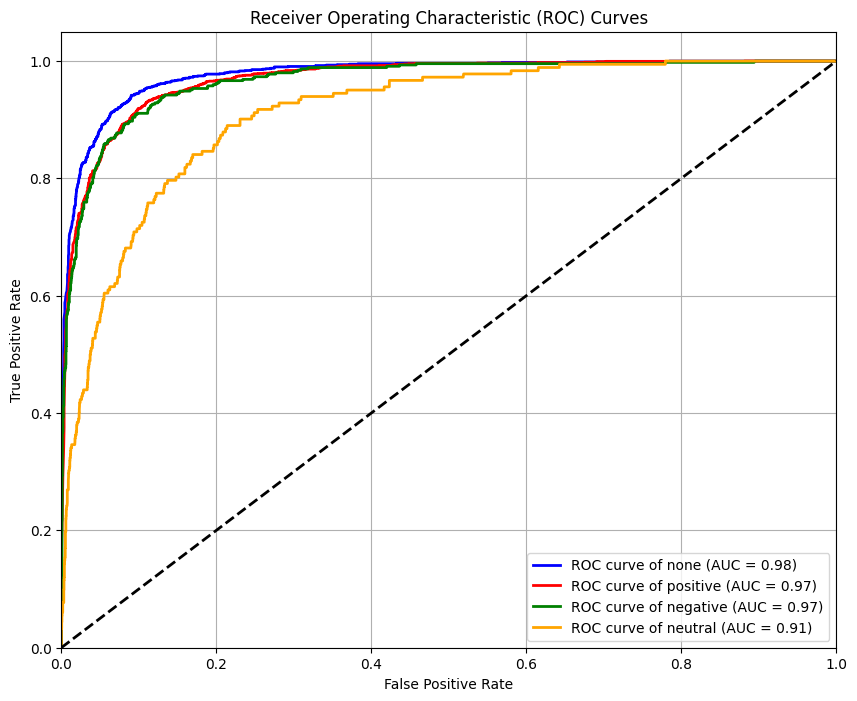

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize 
import numpy as np
import torch

def plot_roc_curves(model, trainer=None, data_module=None):
    if not model.test_outputs:
        if trainer is None or data_module is None:
            raise ValueError("test_outputs is empty. Please provide trainer and data_module to run test.")
        print("test_outputs is empty. Running test to populate it...")
        trainer.test(model, datamodule=data_module)

    preds = torch.cat([x['preds'] for x in model.test_outputs]).detach().cpu().numpy()
    labels = torch.cat([x['labels'] for x in model.test_outputs]).detach().cpu().numpy()
    logits = torch.cat([x['logits'] for x in model.test_outputs]).detach().cpu().numpy()
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
    
    n_classes = 4
    labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])
    class_names = ['none', 'positive', 'negative', 'neutral']
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curves(loaded_model, trainer, data_module)

In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import torch

def evaluate_absa_model(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Đánh giá mô hình ABSA trên GPU:
    - Positive/Negative/Neutral đoán khác None thì đúng
    - None đoán đúng None thì đúng
    
    Parameters:
    - model: Mô hình ABSA đã được huấn luyện
    - dataloader: DataLoader chứa dữ liệu đánh giá
    - device: Thiết bị tính toán (mặc định là GPU nếu có, nếu không thì CPU)
    
    Returns:
    - Dict chứa các metric đánh giá
    """
    model.to(device)
    model.eval()
    
    # Lưu trữ kết quả dự đoán và nhãn thực tế trên GPU
    all_preds = []
    all_labels = []
    
    # Kết quả chi tiết
    results = {
        'total_samples': 0,
        'correct_predictions': 0,
        'aspect_correct': 0,
        'sentiment_correct': 0
    }
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Dự đoán trên GPU
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)  # Giữ preds trên GPU
            
            # Đánh giá từng mẫu trên GPU
            for pred, label in zip(preds, labels):
                results['total_samples'] += 1
                
                # Định nghĩa các lớp sentiment
                sentiment_classes = torch.tensor([1, 2, 3], device=device)  # positive, negative, neutral
                
                # Kiểm tra aspect (none hay không none)
                pred_is_none = (pred == 0)
                label_is_none = (label == 0)
                aspect_correct = (pred_is_none == label_is_none)
                if aspect_correct:
                    results['aspect_correct'] += 1
                
                # Kiểm tra sentiment
                sentiment_correct = False
                if pred_is_none and label_is_none:  # Cả hai đều là none
                    sentiment_correct = True
                elif not pred_is_none and not label_is_none:  # Cả hai đều không phải none
                    sentiment_correct = True
                
                if sentiment_correct:
                    results['sentiment_correct'] += 1
                
                # Tổng hợp đúng cả aspect và sentiment
                if pred == label:
                    results['correct_predictions'] += 1
                
                # Lưu trữ preds và labels trên GPU
                all_preds.append(pred)
                all_labels.append(label)
    
    # Chuyển dữ liệu về CPU để tính toán metric bằng sklearn
    all_preds = torch.stack(all_preds).cpu().numpy()
    all_labels = torch.stack(all_labels).cpu().numpy()
    
    # Tính toán các metric
    results['overall_accuracy'] = results['correct_predictions'] / results['total_samples']
    results['aspect_accuracy'] = results['aspect_correct'] / results['total_samples']
    results['sentiment_accuracy'] = results['sentiment_correct'] / results['total_samples']
    
    results['classification_report'] = classification_report(
        all_labels, 
        all_preds, 
        target_names=['none', 'positive', 'negative', 'neutral']
    )
    results['confusion_matrix'] = confusion_matrix(all_labels, all_preds)
    
    return results

def print_absa_evaluation_results(results):
    """
    In kết quả đánh giá ABSA
    
    Parameters:
    - results: Kết quả trả về từ hàm evaluate_absa_model
    """
    print("ABSA Model Evaluation Results:")
    print("-" * 40)
    print(f"Total Samples: {results['total_samples']}")
    print(f"Overall Correct Predictions: {results['correct_predictions']} "
          f"({results['overall_accuracy']*100:.2f}%)")
    print(f"Aspect Correct: {results['aspect_correct']} "
          f"({results['aspect_accuracy']*100:.2f}%)")
    print(f"Sentiment Correct: {results['sentiment_correct']} "
          f"({results['sentiment_accuracy']*100:.2f}%)")
    print("\nClassification Report:")
    print(results['classification_report'])
    print("\nConfusion Matrix:")
    print(results['confusion_matrix'])

# Giả sử ABSADataModule đã được định nghĩa trước đó
data_module = ABSADataModule(train_df, val_df, test_df)
data_module.setup()
test_dataloader = data_module.test_dataloader()

# Đánh giá mô hình trên GPU
results = evaluate_absa_model(model, test_dataloader, device='cuda' if torch.cuda.is_available() else 'cpu')
print_absa_evaluation_results(results)

ABSA Model Evaluation Results:
----------------------------------------
Total Samples: 3919
Overall Correct Predictions: 3401 (86.78%)
Aspect Correct: 3630 (92.63%)
Sentiment Correct: 3630 (92.63%)

Classification Report:
              precision    recall  f1-score   support

        none       0.88      0.90      0.89      1303
    positive       0.90      0.93      0.91      1985
    negative       0.78      0.74      0.76       449
     neutral       0.52      0.35      0.42       182

    accuracy                           0.87      3919
   macro avg       0.77      0.73      0.74      3919
weighted avg       0.86      0.87      0.86      3919


Confusion Matrix:
[[1167   88   38   10]
 [  92 1839   25   29]
 [  48   49  331   21]
 [  13   75   30   64]]


In [ ]:
import numpy as np

precision = np.array([0.88, 0.90, 0.78, 0.52])
recall = np.array([0.90, 0.93, 0.74, 0.35])
f1_score = np.array([0.89, 0.91, 0.76, 0.42])
support = np.array([1303, 1985, 449, 182])

precision = precision[1:]
recall = recall[1:]
f1_score = f1_score[1:]
support = support[1:]

macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1_score = np.mean(f1_score)

weighted_precision = np.sum(precision * support) / np.sum(support)
weighted_recall = np.sum(recall * support) / np.sum(support)
weighted_f1_score = np.sum(f1_score * support) / np.sum(support)

macro_avg = {
    'precision': macro_precision,
    'recall': macro_recall,
    'f1-score': macro_f1_score
}

weighted_avg = {
    'precision': weighted_precision,
    'recall': weighted_recall,
    'f1-score': weighted_f1_score
}

macro_avg, weighted_avg


({'precision': 0.7333333333333334,
  'recall': 0.6733333333333333,
  'f1-score': 0.6966666666666667},
 {'precision': 0.8529663608562692,
  'recall': 0.8570374617737004,
  'f1-score': 0.8501643730886851})

In [51]:
def generate_result_file(test_df, output_file_path='test_results.txt'):
    """
    Tạo file kết quả từ test_df theo định dạng yêu cầu.
    
    Parameters:
    - test_df: DataFrame chứa dữ liệu test với các cột 'sentence', 'aspect', 'sentiment'
    - output_file_path: Đường dẫn tới file kết quả
    """
    # Nhóm theo sentence để tạo định dạng mong muốn
    grouped = test_df.groupby('sentence')
    
    # Mở file để ghi
    with open(output_file_path, 'w', encoding='utf-8') as f:
        for idx, (sentence, group) in enumerate(grouped, 1):
            # Ghi số thứ tự
            f.write(f"#{idx}\n")
            # Ghi câu đánh giá
            f.write(f"{sentence}\n")
            # Lọc các cặp aspect-sentiment (loại bỏ sentiment = 'none')
            aspects_sentiments = group[group['sentiment'] != 'none'][['aspect', 'sentiment']]
            # Tạo chuỗi các cặp {aspect, sentiment}
            aspect_sentiment_pairs = [f"{{{row['aspect']}, {row['sentiment']}}}" 
                                    for _, row in aspects_sentiments.iterrows()]
            # Ghi các cặp, cách nhau bằng dấu phẩy
            f.write(", ".join(aspect_sentiment_pairs) + "\n\n")
    
    print(f"File kết quả đã được tạo tại: {output_file_path}")

generate_result_file(test_df, output_file_path='test_results.txt')

File kết quả đã được tạo tại: test_results.txt
